In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import numpy as np
import cv2
import time
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def load_images_labels(img_folder, label_file):
    with open(label_file) as f:
        reader = csv.reader(f)
        next(reader) # skip header
        labels = []
        images = []
        for row in reader:
            img_filename = row[0]
            img = mpimg.imread(os.path.join(img_folder,img_filename))
            if img is not None:
                images.append(img)#.flatten()/255)
                labels.append(int(row[1]))
        return np.array(images), np.array(labels)

training_imgs, training_labels = load_images_labels('train/', 'train.csv')

In [3]:
size_training_imgs = training_imgs.shape
print(training_imgs)
Mean_RGB = np.array([128.41563722, 115.24518493, 119.38645491])
Std_RGB = np.array([38.55379149, 35.64913446, 39.07419321])
n_training_imgs = (training_imgs - Mean_RGB)/Std_RGB
n_training_imgs = np.reshape(n_training_imgs, (size_training_imgs[0], 32*32*3))

[[[[136 138 125]
   [134 136 125]
   [147 148 140]
   ...
   [152 129 135]
   [147 124 130]
   [157 134 140]]

  [[124 126 113]
   [161 163 152]
   [158 159 151]
   ...
   [163 140 146]
   [147 126 131]
   [145 124 129]]

  [[161 163 150]
   [160 162 151]
   [158 159 151]
   ...
   [150 129 134]
   [161 140 145]
   [129 108 113]]

  ...

  [[137 111 122]
   [197 171 182]
   [110  84  95]
   ...
   [159 132 149]
   [145 118 135]
   [156 129 146]]

  [[150 124 135]
   [169 143 154]
   [150 124 137]
   ...
   [167 140 157]
   [152 123 141]
   [152 123 143]]

  [[183 157 168]
   [115  89 100]
   [165 139 152]
   ...
   [179 150 168]
   [142 113 133]
   [139 110 130]]]


 [[[118 109 114]
   [108  99 104]
   [104  95 100]
   ...
   [158 132 143]
   [138 112 123]
   [123  97 108]]

  [[133 124 129]
   [123 114 119]
   [117 108 113]
   ...
   [135 109 120]
   [119  93 104]
   [116  90 101]]

  [[150 141 144]
   [125 116 119]
   [107  98 103]
   ...
   [ 99  73  84]
   [103  77  88]
   [125  99

In [4]:
print(len(n_training_imgs))
print(len(training_labels))

17500
17500


In [5]:
print(n_training_imgs[0:5])

[[ 0.19672158  0.63829923  0.14366375 ...  0.27453494 -0.14713358
   0.27162544]
 [-0.27015857 -0.17518476 -0.13785198 ... -0.06265628 -0.14713358
   0.04129439]
 [ 0.76735288  0.6663504   0.98821094 ...  0.61172616  0.30168517
   0.39958714]
 [ 0.48203723  0.49804337  0.68110287 ...  0.24859715 -0.06298007
   0.32281012]
 [-0.3998475  -0.45569648 -0.5473294  ... -0.01078071  0.61024806
  -0.24022134]]


In [6]:
# calculate priors 
prior_class_0 = len(training_labels[training_labels[:]==0])/len(training_labels)
prior_class_1 = len(training_labels[training_labels[:]==1])/len(training_labels)

print(prior_class_0)
print(prior_class_1)

0.24937142857142858
0.7506285714285714


In [7]:
#transform data using PCA
def PCA(X, error):
    
    print(error)
    
    # calculate covariance matrix of transpose of X
    X_cov = np.cov(X.T)
    eig_vals, eig_vects = np.linalg.eig(X_cov)
    
    # rank eigenvectors and values from highest to lowest
    idx = eig_vals.argsort()[::-1]   
    eig_vals = eig_vals[idx]
    eig_vects = eig_vects[:,idx]
    
    # sum eigenvalues
    sigma_lamda = np.sum(eig_vals)
    
    basis_i = 0  
    
    # select axes with error rate < error
    for i in range(len(eig_vals)-1, -1, -1):
        
        vals_sum = np.sum(eig_vals[i:])
        
        if (vals_sum/sigma_lamda >= error):
            basis_i = i
            break
    
    # multiply dataset by optimal basis 
    P = np.dot(eig_vects[:, :basis_i+1].T , X.T)  
    
    return P.T

# reduce normalized datasets using error rate < 0.10
'''p_training_imgs_0_01 = PCA(n_training_imgs, 0.01)
p_training_imgs_0_05 = PCA(n_training_imgs, 0.05)
p_training_imgs_0_1 = PCA(n_training_imgs, 0.1)
p_training_imgs_0_15 = PCA(n_training_imgs, 0.15)
p_training_imgs_0_2 = PCA(n_training_imgs, 0.2)
p_training_imgs_0_25 = PCA(n_training_imgs, 0.25)
p_training_imgs_0_3 = PCA(n_training_imgs, 0.3)
p_training_imgs_0_35 = PCA(n_training_imgs, 0.35)
p_training_imgs_0_4 = PCA(n_training_imgs, 0.4)'''
p_training_imgs_0_45 = PCA(n_training_imgs, 0.45)
p_training_imgs_0_5 = PCA(n_training_imgs, 0.5)
p_training_imgs_0_55 = PCA(n_training_imgs, 0.55)
p_training_imgs_0_6 = PCA(n_training_imgs, 0.6)
print(p_training_imgs_0_5)
print(p_training_imgs_0_5.shape)

0.45
0.5
0.55
0.6
[[-29.94074365   1.72754794   5.11200181   2.25943268   1.24881991]
 [ -5.08118002  13.38036557   6.68362505  -6.91213878   6.39593127]
 [-28.68901359   4.87196245  -8.20554382  -5.59953733   4.89753078]
 ...
 [ -2.17015128   7.53213772  -7.39882982   0.91154427  -5.2785461 ]
 [-20.97945248  -2.17865192   1.33181133   0.55790314  -0.33851133]
 [ -7.80848722 -12.22778193  -6.26199341   1.08672958  -3.25325517]]
(17500, 5)


In [8]:
p_training_imgs_0_01 = PCA(n_training_imgs, 0.01)
p_training_imgs_0_05 = PCA(n_training_imgs, 0.05)
p_training_imgs_0_1 = PCA(n_training_imgs, 0.1)
p_training_imgs_0_15 = PCA(n_training_imgs, 0.15)
p_training_imgs_0_2 = PCA(n_training_imgs, 0.2)
p_training_imgs_0_25 = PCA(n_training_imgs, 0.25)
p_training_imgs_0_3 = PCA(n_training_imgs, 0.3)
p_training_imgs_0_35 = PCA(n_training_imgs, 0.35)
p_training_imgs_0_4 = PCA(n_training_imgs, 0.4)

0.01
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4


In [9]:
# function for calculating sample mean
def mle_mean(data):
    n = len(data)
    mean = np.sum(data, axis=0)/n
    return mean
def FLD(X, y):
    X_0 = X[y[:] == 0.0]
    X_1 = X[y[:] == 1.0]
    
    m_0 = mle_mean(X_0)
    m_1 = mle_mean(X_1)
    
    X = X.T
    X_0 = X_0.T
    X_1 = X_1.T
    
    m_0 = m_0.reshape(len(m_0), 1)
    m_1 = m_1.reshape(len(m_1), 1)
    
    S_0 = np.dot((X_0 - m_0), (X_0 - m_0).T)
    S_1 = np.dot((X_1 - m_1), (X_1 - m_1).T)
    
    S_w = S_0 + S_1
    
    w = np.dot(np.linalg.inv(S_w), m_0 - m_1)

    fX = np.dot(w.T, X)

    return fX.reshape(fX.shape[1], 1)
    
f_training_images = FLD(n_training_imgs, training_labels)

In [21]:
# function for printing confusion matrix and performance metrics
def get_metrics(y_pred, y_truth, print_metrics = False, save=False, name='matrix.csv'):
    tn = 0
    tp = 0 
    fn = 0 
    fp = 0
    
    for i in range(len(y_pred)):
        #calc TP
        if y_pred[i] == 1 and y_truth[i] == 1:
            tp += 1
    
        #calc TN 
        if y_pred[i] == 0 and y_truth[i] == 0:
            tn += 1
    
        #calc FP
        if y_pred[i] == 1 and y_truth[i] == 0:
            fp += 1
    
        #calc FN
        if y_pred[i] == 0 and y_truth[i] == 1:
            fn += 1
    
    if (print_metrics):
        # print confusion matrix
        print('\t\tPredicted Class')
        print('True Class\t', 'No', '\tYes')
        print('No\t\t', tn, '\t', fp)
        print('Yes\t\t', fn, '\t', tp )
        print()
    
    if (tn + tp + fn + fp) == 0.0:
        accuracy = 0.0
    else:
        accuracy = (tn + tp) / (tn + tp + fn + fp)
    
    if (tp + fn) == 0.0:
        sensitivity = 0.0
    else:
        sensitivity = tp / (tp + fn)  
    
    if (tp + fp) == 0.0:
        precision = 0.0
    else:
        precision = tp / (tp + fp)
    
    if (tn + fp) == 0.0:
        specificity = 0.0
    else:
        specificity = tn / (tn + fp)
    
    if print_metrics:
        print('Accuracy', accuracy)
        print('Sensitivity', sensitivity)
        print('Precision', precision)
        print('Specificity', specificity)
        
    if save:
        mat = np.asarray([ [tn, fp], [fn, tp] ])
        np.savetxt(name + '.csv', mat, delimiter=",")
        np.savetxt(name+'_pred.csv', y_pred, delimiter=",")
    
    return accuracy, sensitivity, precision, specificity, tp, tn, fp, fn

In [11]:
# function for finding MLE mean
def mle_mean(data):
    n = len(data)
    mean = np.sum(data, axis=0)/n
    return mean

# function for calculating covariance using MLE given mu
def mle_covariance(data, mu):
    
    n = len(data)
    diff = data - mu
    diff = diff.T
    product = np.matmul(diff, diff.T)
    covariance = product/n
    
    return covariance

# main maximum a-posteriori probability method
# returns test accuracy given test dataset and parameters
def mpp(X_train, y_train, X_test, prior_class_0, prior_class_1, case):
    
    # get dimension of data
    if X_train.ndim == 1:
        d = 1
        X_train = X_train.reshape(len(X_train), 1)
    else:
        d = X_train.shape[1]
        
    #print('d', d)
    
    # split training data into classes
    X_train_class_0 = X_train[y_train[:] == 0.0]
    X_train_class_1 = X_train[y_train[:] == 1.0]
    
    # predict class for each value in test dataset
    y_pred = []
    
    # get MLE mean for individual classes
    mean = mle_mean(X_train).reshape(d,1)
    mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
    mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
    
    cov_mat0 = mle_covariance(X_train_class_0, mean_class_0.T)
    cov_mat1 = mle_covariance(X_train_class_1, mean_class_1.T)
    print('det 0', np.linalg.det(cov_mat0))
    
    print('det 1', np.linalg.det(cov_mat1))
    
    count = 0 
    for x in X_test:
        if count % 1000 == 0:
            print(count)
        count += 1
        
        x = x.reshape(d,1)
        
        # Case 1: Assume Gaussian PDF, covariance matrices are same, & independent features
        # Also known Euclidean Norm or Minimum Distance Classifier
        if case == 1:
            # get MLE mean for individual classes
            mean = mle_mean(X_train).reshape(d,1)
            mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
            mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
            
            # calculate single covariance matrix
            #print('calc cov')
            cov_mat = mle_covariance(X_train, mean.T)#np.cov(X_train[:,0], X_train[:,1])
            
            # calculate discriminant function for class 0
            v = x - mean_class_0
            g0 = -0.5*np.matmul(v.T, v)/cov_mat[0,0] + np.log(prior_class_0)

            # calculate discriminant function for class 1
            v = x - mean_class_1
            g1 = -0.5*np.matmul(v.T, v)/cov_mat[0,0] + np.log(prior_class_1)
            
        # Case 2: Assume Gaussian PDF & covariance matrices are same
        # Also known Squared Mahalanobis Distance Classifier
        elif case == 2:
            # get MLE mean for individual classes
            mean = mle_mean(X_train).reshape(d,1)
            mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
            mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
            
            # calculate single covariance matrix
            cov_mat = mle_covariance(X_train, mean.T)*10.0#cov_mat = np.cov(X_train[:,0], X_train[:,1])
            invC = np.linalg.inv(cov_mat)
            
            # calculate discriminant function for class 0
            v = x - mean_class_0
            g0 = -0.5*np.matmul(np.matmul(v.T, invC), v) + np.log(prior_class_0)

            # calculate discriminant function for class 1
            v = x - mean_class_1
            g1 = -0.5*np.matmul(np.matmul(v.T, invC), v) + np.log(prior_class_1)

        # Case 3: Assume Gaussian PDF only
        # Equivalent of MPP method
        else:
            
            # get MLE mean for individual classes
            mean = mle_mean(X_train).reshape(d,1)
            mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
            mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
            
            # calculate covariance matrices for both classes
            #print(X_train_class_0, mean_class_0.T)
            cov_mat0 = mle_covariance(X_train_class_0, mean_class_0.T)
            cov_mat1 = mle_covariance(X_train_class_1, mean_class_1.T)
            
            # calculate discriminant function for class 0
            v = x - mean_class_0
            invC = np.linalg.inv(cov_mat0)
            #print('det 0', np.linalg.det(cov_mat0))
            g0 = -0.5*np.matmul(np.matmul(v.T, invC), v) - 0.5*np.log(np.linalg.det(cov_mat0)) + np.log(prior_class_0)
        
            # calculate discriminant function for class 1
            v = x - mean_class_1
            invC = np.linalg.inv(cov_mat1)
            g1 = -0.5*np.matmul(np.matmul(v.T, invC), v) - 0.5*np.log(np.linalg.det(cov_mat1)) + np.log(prior_class_1)
            #print('det 1', np.linalg.det(cov_mat1))
        
        # append classification 
        if g0 > g1:
            y_pred.append(0.0)
        else:
            y_pred.append(1.0)
            
    return y_pred

In [12]:
# function for training MPP classifier with 5-fold cross validation
def train_mpp_with_validation(X_train, y_train, case, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):
        

        print('fold', f)

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))


        # calculate priors 
        prior_class_0 = len(y_train_tmp[y_train_tmp[:]==0])/len(y_train_tmp)
        prior_class_1 = len(y_train_tmp[y_train_tmp[:]==1])/len(y_train_tmp)
        
                
        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # MPP Case 1
        if case == 1:
            y_pred_valid = mpp(X_train, y_train, X_valid, prior_class_0, prior_class_1, case)
        
        # MPP Case 2
        elif case == 2:
            y_pred_valid = mpp(X_train, y_train, X_valid, prior_class_0, prior_class_1, case)
        
        # MPP Case 3
        else:
            y_pred_valid = mpp(X_train, y_train, X_valid, prior_class_0, prior_class_1, case)
            
        performance_metrics = get_metrics(y_pred_valid, y_valid, print_metrics = True)
        
        print('predicted labels', y_pred_valid)
        print('true labels', y_valid)
        
        
        print(performance_metrics)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [13]:
# function for calculating Euclidean distance
def euc_dist(x, y):
    
    diff = x-y
    
    if(diff.ndim == 1):
        return np.abs(diff)
    
    return np.linalg.norm(diff, axis = 1)

# k-nearest neighbors implementation
def knn(X, y, X_te, prior_class_0, prior_class_1, k):
    
    start_time = time.time()
    
    predictions = np.zeros(len(X_te))
    
    indices = np.array([ind for ind in range(len(X))])
    
    prior_class_0_actual = len(X[y[:] == 0.0])/len(X)
    prior_class_1_actual = len(X[y[:] == 1.0])/len(X)
    
    for i in range(len(X_te)):
        s = euc_dist(X_te[i], X)
        s = np.column_stack((indices, s))
        s = s[s[:,1].argsort()]
        
        # get k nearest neighbors
        knns = s[:k]
        classes = []
        
        for ind in knns[:,0]:
            classes.append(int(y[int(ind)]))
    
        k_0 = classes.count(0)
        
        n = len(X)
        
        r_0 = prior_class_0 * prior_class_0_actual
        
        g_0 = k_0 / k * r_0
        
        k_1 = classes.count(1)
    
        g_1 = k_1 / k * (1.0 - prior_class_0_actual * r_0)
    
        predictions[i] = g_0 < g_1
    
    end_time = time.time()
    
    print("Elapsed Time:", end_time - start_time)
    
    return predictions

def train_knn_with_validation(X_train, y_train, k, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))

        # calculate priors 
        prior_class_0 = len(y_train_tmp[y_train_tmp[:]==0])/len(y_train_tmp)
        prior_class_1 = len(y_train_tmp[y_train_tmp[:]==1])/len(y_train_tmp)
        
                
        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # KNN
        y_pred_valid = knn(X_train_tmp, y_train_tmp, X_valid, prior_class_0, prior_class_1, k)
        
        performance_metrics = get_metrics(y_pred_valid, y_valid)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [116]:
# mpp case 1
train_mpp_with_validation(p_training_imgs, training_labels, 1, folds=5)
train_mpp_with_validation(f_training_images, training_labels, 1, folds=5)

fold 0
0
1000
2000
3000
Fold 1 accuracy: 0.748
fold 1
0
1000
2000
3000
Fold 2 accuracy: 0.7417142857142857
fold 2
0
1000
2000
3000
Fold 3 accuracy: 0.7534285714285714
fold 3
0
1000
2000
3000
Fold 4 accuracy: 0.7625714285714286
fold 4
0
1000
2000
3000
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7509714285714286
fold 0
0
1000
2000
3000
Fold 1 accuracy: 0.7917142857142857
fold 1
0
1000
2000
3000
Fold 2 accuracy: 0.784
fold 2
0
1000
2000
3000
Fold 3 accuracy: 0.7971428571428572
fold 3
0
1000
2000
3000
Fold 4 accuracy: 0.8054285714285714
fold 4
0
1000
2000
3000
Fold 5 accuracy: 0.7934285714285715
Mean validation accuracy: 0.7943428571428571


array([7.94342857e-01, 8.05911913e-01, 9.56387558e-01, 7.00274195e-01,
       2.51260000e+03, 2.67600000e+02, 1.14600000e+02, 6.05200000e+02])

In [118]:
# mpp case 2
train_mpp_with_validation(p_training_imgs, training_labels, 2, folds=5)
train_mpp_with_validation(f_training_images, training_labels, 2, folds=5)

fold 0
0
1000
2000
3000
Fold 1 accuracy: 0.7474285714285714
fold 1
0
1000
2000
3000
Fold 2 accuracy: 0.7417142857142857
fold 2
0
1000
2000
3000
Fold 3 accuracy: 0.7525714285714286
fold 3
0
1000
2000
3000
Fold 4 accuracy: 0.7622857142857142
fold 4
0
1000
2000
3000
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713
fold 0
0
1000
2000
3000
Fold 1 accuracy: 0.7474285714285714
fold 1
0
1000
2000
3000
Fold 2 accuracy: 0.7417142857142857
fold 2
0
1000
2000
3000
Fold 3 accuracy: 0.7525714285714286
fold 3
0
1000
2000
3000
Fold 4 accuracy: 0.7622857142857142
fold 4
0
1000
2000
3000
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713


array([7.50628571e-01, 7.50628571e-01, 1.00000000e+00, 0.00000000e+00,
       2.62720000e+03, 0.00000000e+00, 0.00000000e+00, 8.72800000e+02])

In [170]:
# mpp case 3
train_mpp_with_validation(p_training_imgs, training_labels, 3, folds=5)
train_mpp_with_validation(f_training_images, training_labels, 3, folds=5)

fold 0
det 0 0.0012435682827854468
det 1 0.004407162183016091
0
1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 391 	 493
Yes		 232 	 2384

Accuracy 0.7928571428571428
Sensitivity 0.9113149847094801
Precision 0.8286409454292666
Specificity 0.4423076923076923
predicted labels [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 397 	 507
Yes		 233 	 2363

Accuracy 0.7885714285714286
Sensitivity 0.9102465331278891
Precision 0.8233449477351916
Specificity 0.4391592920353982
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 414 	 452
Yes		 263 	 2371

Accuracy 0.7957142857142857
Sensitivity 0.9001518602885346
Precision 0.8398866454126815
Specificity 0.4780600461893764
predicted labels [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 380 	 452
Yes		 248 	 2420

Accuracy 0.8
Sensitivity 0.9070464767616192
Precision 0.8426183844011143
Specificity 0.4567307692307692
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 391 	 487
Yes		 234 	 2388

Accuracy 0.794
Sensitivity 0.9107551487414187
Precision 0.8306086956521739
Specificity 0.44533029612756264
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0,

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 466 	 418
Yes		 218 	 2398

Accuracy 0.8182857142857143
Sensitivity 0.9166666666666666
Precision 0.8515625
Specificity 0.5271493212669683
predicted labels [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 453 	 451
Yes		 210 	 2386

Accuracy 0.8111428571428572
Sensitivity 0.9191063174114021
Precision 0.8410292562566091
Specificity 0.5011061946902655
predicted labels [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 480 	 386
Yes		 243 	 2391

Accuracy 0.8202857142857143
Sensitivity 0.907744874715262
Precision 0.8610010803024847
Specificity 0.5542725173210161
predicted labels [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 451 	 381
Yes		 239 	 2429

Accuracy 0.8228571428571428
Sensitivity 0.9104197901049476
Precision 0.8644128113879004
Specificity 0.5420673076923077
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 467 	 411
Yes		 238 	 2384

Accuracy 0.8145714285714286
Sensitivity 0.9092295957284515
Precision 0.8529516994633274
Specificity 0.5318906605922551
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.

array([8.17428571e-01, 9.12633449e-01, 8.54191469e-01, 5.31297200e-01,
       2.39760000e+03, 4.63400000e+02, 4.09400000e+02, 2.29600000e+02])

In [18]:
# train and test knn classifier for different k values: nX
p_validation_accuracies = []
f_validation_accuracies = []
'''for k in range(1, 50):
    p_validation_accuracies.append(train_knn_with_validation(p_training_imgs, training_labels, prior_class_0, prior_class_1, k, folds=5)[0])
    f_validation_accuracies.append(train_knn_with_validation(f_training_images, training_labels, prior_class_0, prior_class_1, k, folds=5)[0])
'''    
    
# plot KNN accuracies

def plot_accuracies(k, accuracies, methods, title, xlabel, ylabel):
    
    for i in range(len(accuracies)):
        plt.plot(k, accuracies[i], label=methods[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
'''k = [i for i in range(1, 50)]
accuracies = [p_validation_accuracies, f_validation_accuracies]
methods = ['PCA Validation Accuracy', 'FLD Validation Accuracy']
plot_accuracies(k, accuracies, methods, 'KNN Validation Accuracies', 'K', 'Accuracy')
'''
# knn
train_knn_with_validation(n_training_imgs, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 1000.5520312786102
Fold 1 accuracy: 0.5948571428571429
Elapsed Time: 982.996691942215
Fold 2 accuracy: 0.5994285714285714
Elapsed Time: 1020.8932321071625
Fold 3 accuracy: 0.5974285714285714
Elapsed Time: 1041.4934697151184
Fold 4 accuracy: 0.5657142857142857
Elapsed Time: 1069.1344487667084
Fold 5 accuracy: 0.5991428571428571
Mean validation accuracy: 0.5913142857142858


array([5.91314286e-01, 5.54243631e-01, 8.48980457e-01, 7.03214541e-01,
       1.45580000e+03, 6.13800000e+02, 2.59000000e+02, 1.17140000e+03])

In [233]:
train_knn_with_validation(p_training_imgs_0_01, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 308.57925295829773
Fold 1 accuracy: 0.6037142857142858
Elapsed Time: 313.7868220806122
Fold 2 accuracy: 0.6094285714285714
Elapsed Time: 312.0182168483734
Fold 3 accuracy: 0.6062857142857143
Elapsed Time: 307.602694272995
Fold 4 accuracy: 0.5731428571428572
Elapsed Time: 315.3260004520416
Fold 5 accuracy: 0.6071428571428571
Mean validation accuracy: 0.5999428571428571


array([5.99942857e-01, 5.68946121e-01, 8.48227826e-01, 6.93578703e-01,
       1.49440000e+03, 6.05400000e+02, 2.67400000e+02, 1.13280000e+03])

In [232]:
train_knn_with_validation(f_training_images, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 4.213701009750366
Fold 1 accuracy: 0.8408571428571429
Elapsed Time: 4.204053640365601
Fold 2 accuracy: 0.8474285714285714
Elapsed Time: 4.180605173110962
Fold 3 accuracy: 0.856
Elapsed Time: 4.1983482837677
Fold 4 accuracy: 0.8594285714285714
Elapsed Time: 4.193228721618652
Fold 5 accuracy: 0.8442857142857143
Mean validation accuracy: 0.8495999999999999


array([8.49600000e-01, 9.95059713e-01, 8.35879937e-01, 4.12013766e-01,
       2.61420000e+03, 3.59400000e+02, 5.13400000e+02, 1.30000000e+01])

In [231]:
train_knn_with_validation(p_training_imgs_0_05, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 212.77891635894775
Fold 1 accuracy: 0.6402857142857142
Elapsed Time: 210.62300753593445
Fold 2 accuracy: 0.6417142857142857
Elapsed Time: 211.12775540351868
Fold 3 accuracy: 0.6414285714285715
Elapsed Time: 210.48563623428345
Fold 4 accuracy: 0.6168571428571429
Elapsed Time: 214.8322377204895
Fold 5 accuracy: 0.642
Mean validation accuracy: 0.6364571428571428


array([6.36457143e-01, 6.28677660e-01, 8.47782053e-01, 6.60187835e-01,
       1.65140000e+03, 5.76200000e+02, 2.96600000e+02, 9.75800000e+02])

In [230]:
train_knn_with_validation(p_training_imgs_0_1, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 109.38135504722595
Fold 1 accuracy: 0.6931428571428572
Elapsed Time: 144.0257875919342
Fold 2 accuracy: 0.688
Elapsed Time: 109.38360977172852
Fold 3 accuracy: 0.6977142857142857
Elapsed Time: 143.90456700325012
Fold 4 accuracy: 0.6808571428571428
Elapsed Time: 109.67548179626465
Fold 5 accuracy: 0.6914285714285714
Mean validation accuracy: 0.6902285714285714


array([6.90228571e-01, 7.14420483e-01, 8.49018830e-01, 6.17644581e-01,
       1.87680000e+03, 5.39000000e+02, 3.33800000e+02, 7.50400000e+02])

In [229]:
train_knn_with_validation(p_training_imgs_0_15, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 52.50779628753662
Fold 1 accuracy: 0.7434285714285714
Elapsed Time: 52.41184854507446
Fold 2 accuracy: 0.736
Elapsed Time: 52.52148222923279
Fold 3 accuracy: 0.7502857142857143
Elapsed Time: 52.36537170410156
Fold 4 accuracy: 0.7305714285714285
Elapsed Time: 52.74419403076172
Fold 5 accuracy: 0.7402857142857143
Mean validation accuracy: 0.7401142857142857


array([7.40114286e-01, 7.93662464e-01, 8.50186352e-01, 5.79069671e-01,
       2.08500000e+03, 5.05400000e+02, 3.67400000e+02, 5.42200000e+02])

In [228]:
train_knn_with_validation(p_training_imgs_0_2, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 37.73424959182739
Fold 1 accuracy: 0.788
Elapsed Time: 36.800321102142334
Fold 2 accuracy: 0.774
Elapsed Time: 36.75084400177002
Fold 3 accuracy: 0.7891428571428571
Elapsed Time: 37.059221029281616
Fold 4 accuracy: 0.7668571428571429
Elapsed Time: 37.13125777244568
Fold 5 accuracy: 0.7742857142857142
Mean validation accuracy: 0.7784571428571428


array([7.78457143e-01, 8.53053862e-01, 8.52019811e-01, 5.54038449e-01,
       2.24100000e+03, 4.83600000e+02, 3.89200000e+02, 3.86200000e+02])

In [227]:
train_knn_with_validation(p_training_imgs_0_25, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 26.173298835754395
Fold 1 accuracy: 0.8125714285714286
Elapsed Time: 26.16085457801819
Fold 2 accuracy: 0.806
Elapsed Time: 25.95589852333069
Fold 3 accuracy: 0.8151428571428572
Elapsed Time: 26.14486050605774
Fold 4 accuracy: 0.8014285714285714
Elapsed Time: 26.196364164352417
Fold 5 accuracy: 0.8042857142857143
Mean validation accuracy: 0.8078857142857144


array([8.07885714e-01, 8.99487821e-01, 8.52709399e-01, 5.32331143e-01,
       2.36300000e+03, 4.64600000e+02, 4.08200000e+02, 2.64200000e+02])

In [226]:
train_knn_with_validation(p_training_imgs_0_3, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 18.183197736740112
Fold 1 accuracy: 0.8311428571428572
Elapsed Time: 18.300961017608643
Fold 2 accuracy: 0.8331428571428572
Elapsed Time: 18.28434729576111
Fold 3 accuracy: 0.8428571428571429
Elapsed Time: 18.04422163963318
Fold 4 accuracy: 0.834
Elapsed Time: 18.171581268310547
Fold 5 accuracy: 0.8308571428571428
Mean validation accuracy: 0.8343999999999999


array([8.34400000e-01, 9.44002205e-01, 8.51537669e-01, 5.04671886e-01,
       2.48000000e+03, 4.40400000e+02, 4.32400000e+02, 1.47200000e+02])

In [225]:
train_knn_with_validation(p_training_imgs_0_35, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 12.457399129867554
Fold 1 accuracy: 0.8482857142857143
Elapsed Time: 12.479574203491211
Fold 2 accuracy: 0.8454285714285714
Elapsed Time: 12.590526103973389
Fold 3 accuracy: 0.8511428571428571
Elapsed Time: 12.562794923782349
Fold 4 accuracy: 0.8517142857142858
Elapsed Time: 12.437313318252563
Fold 5 accuracy: 0.8437142857142857
Mean validation accuracy: 0.8480571428571428


array([8.48057143e-01, 9.75658748e-01, 8.45671541e-01, 4.64075879e-01,
       2.56320000e+03, 4.05000000e+02, 4.67800000e+02, 6.40000000e+01])

In [224]:
train_knn_with_validation(p_training_imgs_0_4, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 6.993865013122559
Fold 1 accuracy: 0.8454285714285714
Elapsed Time: 7.1112754344940186
Fold 2 accuracy: 0.842
Elapsed Time: 7.061120510101318
Fold 3 accuracy: 0.8474285714285714
Elapsed Time: 7.025096416473389
Fold 4 accuracy: 0.8531428571428571
Elapsed Time: 6.9256134033203125
Fold 5 accuracy: 0.8402857142857143
Mean validation accuracy: 0.8456571428571429


array([8.45657143e-01, 9.92087774e-01, 8.33827606e-01, 4.04940876e-01,
       2.60640000e+03, 3.53400000e+02, 5.19400000e+02, 2.08000000e+01])

In [223]:
train_knn_with_validation(p_training_imgs_0_45, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 5.122336149215698
Fold 1 accuracy: 0.8177142857142857
Elapsed Time: 5.100482225418091
Fold 2 accuracy: 0.8105714285714286
Elapsed Time: 5.092669725418091
Fold 3 accuracy: 0.824
Elapsed Time: 5.08340859413147
Fold 4 accuracy: 0.8291428571428572
Elapsed Time: 5.12052845954895
Fold 5 accuracy: 0.8142857142857143
Mean validation accuracy: 0.8191428571428572


array([8.19142857e-01, 9.97867632e-01, 8.06894347e-01, 2.81313520e-01,
       2.62160000e+03, 2.45400000e+02, 6.27400000e+02, 5.60000000e+00])

In [222]:
train_knn_with_validation(p_training_imgs_0_5, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 4.510916709899902
Fold 1 accuracy: 0.7517142857142857
Elapsed Time: 4.476474761962891
Fold 2 accuracy: 0.748
Elapsed Time: 4.476139545440674
Fold 3 accuracy: 0.7597142857142857
Elapsed Time: 4.465270757675171
Fold 4 accuracy: 0.7737142857142857
Elapsed Time: 4.469052314758301
Fold 5 accuracy: 0.7554285714285714
Mean validation accuracy: 0.7577142857142857


array([7.57714286e-01, 9.99772482e-01, 7.56093228e-01, 2.93573335e-02,
       2.62660000e+03, 2.54000000e+01, 8.47400000e+02, 6.00000000e-01])

In [221]:
train_knn_with_validation(p_training_imgs_0_55, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 4.382814407348633
Fold 1 accuracy: 0.7474285714285714
Elapsed Time: 4.362872123718262
Fold 2 accuracy: 0.7417142857142857
Elapsed Time: 4.333854675292969
Fold 3 accuracy: 0.7525714285714286
Elapsed Time: 4.34569525718689
Fold 4 accuracy: 0.7622857142857142
Elapsed Time: 4.314422845840454
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713


array([7.50628571e-01, 1.00000000e+00, 7.50628571e-01, 0.00000000e+00,
       2.62720000e+03, 0.00000000e+00, 8.72800000e+02, 0.00000000e+00])

In [220]:
train_knn_with_validation(p_training_imgs_0_6, training_labels, int(np.sqrt(len(training_imgs))), folds=5)

Elapsed Time: 4.2237536907196045
Fold 1 accuracy: 0.7474285714285714
Elapsed Time: 4.214142799377441
Fold 2 accuracy: 0.7417142857142857
Elapsed Time: 4.20073390007019
Fold 3 accuracy: 0.7525714285714286
Elapsed Time: 4.1959803104400635
Fold 4 accuracy: 0.7622857142857142
Elapsed Time: 4.204690217971802
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713


array([7.50628571e-01, 1.00000000e+00, 7.50628571e-01, 0.00000000e+00,
       2.62720000e+03, 0.00000000e+00, 8.72800000e+02, 0.00000000e+00])

In [19]:
print(accuracies)

[[0.7716, 0.8071428571428572, 0.8046285714285716, 0.8011428571428573, 0.7969714285714286, 0.7930857142857143, 0.7892571428571429, 0.7873714285714286, 0.7849714285714285, 0.7828571428571428, 0.7806285714285714, 0.7792571428571428, 0.7780571428571429, 0.7765142857142858, 0.7749714285714285, 0.7734285714285715, 0.7892571428571429, 0.7880571428571429, 0.7872, 0.7860571428571429, 0.7846857142857143, 0.7832571428571428, 0.7827428571428572, 0.7816, 0.780457142857143, 0.7793142857142857, 0.7782285714285714, 0.7772571428571429, 0.7763428571428572, 0.7754857142857142, 0.7741714285714286, 0.7735428571428571, 0.7725714285714286, 0.7810285714285714, 0.7802857142857144, 0.7789714285714285, 0.7781142857142858, 0.7773714285714286, 0.7764, 0.7754857142857142, 0.7747428571428572, 0.774, 0.7733142857142857, 0.7722285714285714, 0.7718285714285715, 0.7714285714285715, 0.7706857142857142, 0.7700571428571428, 0.7696000000000001], [0.7581142857142857, 0.7740571428571428, 0.7697714285714286, 0.7643428571428571

In [16]:
# function for k-means clustering
def kmeans(X, k=256):
    
    int_min = np.min(X)
    int_max = np.max(X)
    
    n_features = X.shape[1]
    # initialize means and indices
    prev_k_means = np.array([[0 for i in range(n_features)] for j in range(k)])
    means = np.array([[np.random.uniform(int_min, int_max) for i in range(n_features)] for j in range(k)])
    indices = np.array([ind for ind in range(len(X))])
    
    #print('means', means)
    
    count = 0
    nearest_means = []
    # continue iterations until cluster assignments stop changing or max iterations exceeded
    while not np.array_equal(prev_k_means, means) and count < 1000: 
        #print(count)
        count += 1
        nearest_means = []
        
        # find nearest centroid for each sample
        for x in X:
            s = euc_dist(means, x)
            '''print('s', s)
            print(np.argmin(s))'''
            nearest_means.append(np.argmin(s))
        nearest_means = np.array(nearest_means)
        prev_k_means = means
        means = np.array([[0.0 for i in range(0, n_features)] for i in range(k)])
        
        # update centroids to average of means in cluster
        for k_ in range(k):
            cluster = X[nearest_means[:]==k_]
            #print('len(cluster)', len(cluster))
            if len(cluster) == 0:
                means[k_] = prev_k_means[k_]
            else:
                means[k_] = np.array([np.mean(cluster, axis=0)])

    means = np.array([[int(np.round(means[j,i])) for i in range(n_features)] for j in range(k)])
    return nearest_means, means

def calculate_error(features, nearest_means, means):
    new_features = []
    for i in range(len(nearest_means)):
        new_features.append(means[nearest_means[i]])
    new_features = np.array(new_features)
    return np.square(np.subtract(features, new_features)).mean()


In [266]:
scores = []
ks = [2]
nearest_means, means = kmeans(n_training_imgs, k=2)
#print(training_imgs[0])
print(get_metrics(nearest_means, training_labels))
print(get_metrics(nearest_means, training_labels)[0])

nearest_means, means = kmeans(p_training_imgs_0_5, k=2)
print(get_metrics(nearest_means, training_labels))
print(get_metrics(nearest_means, training_labels)[0])

nearest_means, means = kmeans(f_training_images, k=2)
print(get_metrics(nearest_means, training_labels))
'''print(f_training_images[0])
print(list(nearest_means))
print(list(training_labels))'''
#means_to_img(means, nearest_means, 'figures/kmeans_' + str(k_) + '.png')
#scores.append(calculate_error(features, nearest_means, means))
print(get_metrics(nearest_means, training_labels)[0])

(0.47605714285714285, 0.5294610231425091, 0.6994870763351101, 0.3153070577451879, 6955, 1376, 2988, 6181)
0.47605714285714285
(0.5237714285714286, 0.4703105968331303, 0.8178448504103786, 0.6846929422548121, 6178, 2988, 1376, 6958)
0.5237714285714286
(0.8775428571428572, 0.8453105968331304, 0.9901025412394115, 0.974564619615032, 11104, 4253, 111, 2032)
0.8775428571428572


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

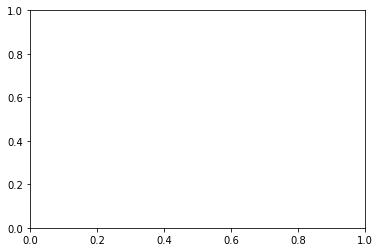

In [267]:
# plot silhouette scores
def plot_error(k, scores, title, xlabel, ylabel, filename):
    
    plt.plot(k, scores)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(filename)
    
plot_error(ks, scores, 'K-Means Errors', 'K', 'Mean Squared Error', 'figures/kmeans_errors.png')

In [14]:
def train_decision_tree_with_validation(X_train, y_train, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))

        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # KNN
        clf = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12, random_state=0).fit(X_train_tmp, y_train_tmp)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
        #classifiers.append(clf)
        y_pred_valid = clf.predict(X_valid)
        
        performance_metrics = get_metrics(y_valid, y_pred_valid)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [270]:
train_decision_tree_with_validation(n_training_imgs, training_labels)

Fold 1 accuracy: 0.8245714285714286
Fold 2 accuracy: 0.8225714285714286
Fold 3 accuracy: 0.8294285714285714
Fold 4 accuracy: 0.8285714285714286
Fold 5 accuracy: 0.8182857142857143
Mean validation accuracy: 0.8246857142857144


array([8.24685714e-01, 8.33644218e-01, 9.57657315e-01, 7.73457522e-01,
       2.51620000e+03, 3.70200000e+02, 1.11000000e+02, 5.02600000e+02])

In [271]:
train_decision_tree_with_validation(p_training_imgs_0_35, training_labels)

Fold 1 accuracy: 0.8742857142857143
Fold 2 accuracy: 0.8717142857142857
Fold 3 accuracy: 0.8754285714285714
Fold 4 accuracy: 0.8774285714285714
Fold 5 accuracy: 0.8705714285714286
Mean validation accuracy: 0.8738857142857143


array([8.73885714e-01, 9.12719871e-01, 9.20033124e-01, 7.53779750e-01,
       2.41720000e+03, 6.41400000e+02, 2.10000000e+02, 2.31400000e+02])

In [272]:
train_decision_tree_with_validation(f_training_images, training_labels)

Fold 1 accuracy: 0.9414285714285714
Fold 2 accuracy: 0.9354285714285714
Fold 3 accuracy: 0.9311428571428572
Fold 4 accuracy: 0.9337142857142857
Fold 5 accuracy: 0.9388571428571428
Mean validation accuracy: 0.9361142857142857


array([9.36114286e-01, 9.51067510e-01, 9.64530558e-01, 8.88419256e-01,
       2.53400000e+03, 7.42400000e+02, 9.32000000e+01, 1.30400000e+02])

In [114]:
svm = SVC()
parameters = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
clf = GridSearchCV(svm, parameters)
clf.fit(f_training_images, training_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.001, 0.0001], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
clf.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'linear'}

In [117]:
# preform fine-grained grid search
parameters = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],'gamma':[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], 'kernel':['rbf']}
clf = GridSearchCV(svm, parameters)
clf.fit(f_training_images, training_labels)
clf.best_params_

{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}

In [15]:
def train_svm_with_validation(X_train, y_train, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))

        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # KNN
        clf = SVC(C=0.07, gamma= 3.0, kernel='rbf').fit(X_train_tmp, y_train_tmp)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
        #classifiers.append(clf)
        y_pred_valid = clf.predict(X_valid)
        
        performance_metrics = get_metrics(y_valid, y_pred_valid)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [15]:
train_svm_with_validation(f_training_images, training_labels)

Fold 1 accuracy: 0.7474285714285714
Fold 2 accuracy: 0.7417142857142857
Fold 3 accuracy: 0.7525714285714286
Fold 4 accuracy: 0.7622857142857142
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713


array([7.50628571e-01, 7.50628571e-01, 1.00000000e+00, 0.00000000e+00,
       2.62720000e+03, 0.00000000e+00, 0.00000000e+00, 8.72800000e+02])

(17500, 1)
(17500,)
Elapsed Time: 3.9280409812927246
knn
dt
svm


In [28]:
def naive_bayes(f_training_images, training_labels):
    
    n_classes = 2
    
    mat_files = ['f_knn.csv', 'f_dt.csv']
    
    # Naive Bayes

    # split 90/10
    ind = int(len(f_training_images)/10)
    f_train = f_training_images[:ind]
    f_test = f_training_images[ind:]
    f_train_labels = training_labels[:ind]
    f_test_labels = training_labels[ind:]
    #f_train, f_test, f_train_labels, f_test_labels = train_test_split(f_training_images, training_labels, test_size=0.20, random_state=42)

    prior_class_0 = len(f_train_labels[f_train_labels[:]==0])/len(f_train_labels)
    prior_class_1 = len(f_train_labels[f_train_labels[:]==1])/len(f_train_labels)
    
    # obtain predicted labels
    # KNN
    y_pred_knn = knn(f_train, f_train_labels, f_test, prior_class_0, prior_class_1, 2)
    performance_metrics = get_metrics(f_test_labels, y_pred_knn, save=True, name='f_knn')

    # DT
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12, random_state=0).fit(f_train, f_train_labels)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
    y_pred_dt = clf.predict(f_test)
    performance_metrics = get_metrics(f_test_labels, y_pred_dt, save=True, name='f_dt')
    
    # SVM
    clf = SVC(C=0.07, gamma= 3.0, kernel='rbf').fit(f_train, f_train_labels)
    y_pred_dt = clf.predict(f_test)
    performance_metrics = get_metrics(f_test_labels, y_pred_dt, save=True, name='f_svm')

    # calculate probability matrices
    prob_mats = []
    
    for mf in mat_files:
        
        mat = np.loadtxt(open(mf, "rb"), delimiter=",")#, skiprows=1)
    
        prob_mat = np.zeros(shape=(2,2))
    
        for i in range(mat.shape[0]):
            # sum rows
            prob_mat[i,:] = mat[i,:]/ np.sum(mat[i,:])
        
        prob_mats.append(prob_mat)
    
    # calculate joint probability matrix
    
    count = 0
    joint_prob_mat = np.zeros(shape=(2,4))
    joint_prob_mat[:,0] = prob_mats[0][:,0]*prob_mats[1][:,0]
    joint_prob_mat[:,1] = prob_mats[0][:,1]*prob_mats[1][:,0]
    joint_prob_mat[:,2] = prob_mats[0][:,0]*prob_mats[1][:,1]
    joint_prob_mat[:,3] = prob_mats[0][:,1]*prob_mats[1][:,1]
    print(joint_prob_mat)

    pred = []
    for i in range(len(f_test_labels)):
        clf1 = y_pred_knn[i]
        clf2 = y_pred_dt[i]
        
        if clf1 == 0 and clf2 == 0:
             pred.append(np.argmax(joint_prob_mat[:,0] ))
            
        if clf1 == 1 and clf2 == 0:
            pred.append(np.argmax(joint_prob_mat[:,1])) 
            
        if clf1 == 0 and clf2 == 1:
            pred.append(np.argmax(joint_prob_mat[:,2])) 
            
        if clf1 == 1 and clf2 == 1:
            pred.append(np.argmax(joint_prob_mat[:,3]))
    
    performance_metrics = get_metrics(pred, f_test_labels)
    return pred

In [29]:
naive_bayes(f_training_images, training_labels)

Elapsed Time: 2.441591739654541
[[0.77824215 0.09820675 0.10970711 0.01384399]
 [0.00378227 0.04482071 0.07403749 0.87735953]]


[1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [25]:
naive_bayes(n_training_imgs, training_labels)

KeyboardInterrupt: 

In [15]:
def plot_roc(fpr, tpr, title):
    
    #auc = np.trapz(tpr, fpr)
    plt.plot(fpr, tpr) #, label="data 1, auc="+str(auc))
    plt.xlabel('FPR (1 - Specificity)')
    plt.ylabel('TPR (Sensitivity)')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(title)
    plt.show()

p0 0.0 p1 1.0
Elapsed Time: 3.9321181774139404
p0 0.05 p1 0.95
Elapsed Time: 3.9110379219055176
p0 0.1 p1 0.9
Elapsed Time: 3.924804449081421
p0 0.15 p1 0.85
Elapsed Time: 3.911306858062744
p0 0.2 p1 0.8
Elapsed Time: 3.915041446685791
p0 0.25 p1 0.75
Elapsed Time: 3.921776533126831
p0 0.3 p1 0.7
Elapsed Time: 3.9219703674316406
p0 0.35 p1 0.65
Elapsed Time: 3.9202158451080322
p0 0.4 p1 0.6
Elapsed Time: 3.91325306892395
p0 0.45 p1 0.55
Elapsed Time: 3.9197723865509033
p0 0.5 p1 0.5
Elapsed Time: 3.9129717350006104
p0 0.55 p1 0.44999999999999996
Elapsed Time: 3.9179162979125977
p0 0.6 p1 0.4
Elapsed Time: 3.9190332889556885
p0 0.65 p1 0.35
Elapsed Time: 3.90871262550354
p0 0.7 p1 0.30000000000000004
Elapsed Time: 3.9295268058776855
p0 0.75 p1 0.25
Elapsed Time: 3.9315221309661865
p0 0.8 p1 0.19999999999999996
Elapsed Time: 3.9219095706939697
p0 0.85 p1 0.15000000000000002
Elapsed Time: 3.901282787322998
p0 0.9 p1 0.09999999999999998
Elapsed Time: 3.9110140800476074
p0 0.95 p1 0.0500000

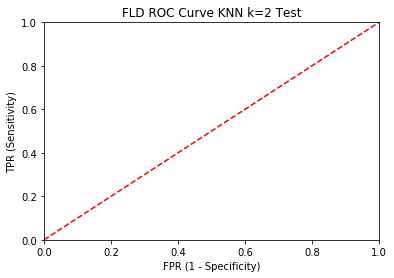

In [24]:
# plot knn roc curve
tpr = []
fpr = []

# split 80/20
f_train, f_test, f_train_labels, f_test_labels = train_test_split(f_training_images, training_labels, test_size=0.20, random_state=42)

for i in range(0, 105, 5):
    p0 = i*1.0 / 100.0
    p1 = 1.0 - p0
    print('p0', p0, 'p1', p1)
    y_pred_knn = knn(f_train, f_train_labels, f_test, p0, p1, 2)
    performance_metrics = get_metrics(f_test_labels, y_pred_knn)
    tpr.append(performance_metrics[0])
    fpr.append(1 - performance_metrics[1])
    
plot_roc(fpr, tpr, 'FLD ROC Curve KNN k=2 Test')

p0 0.0 p1 1.0
Elapsed Time: 12.429692506790161
p0 0.05 p1 0.95
Elapsed Time: 12.436695337295532
p0 0.1 p1 0.9
Elapsed Time: 12.43665337562561
p0 0.15 p1 0.85
Elapsed Time: 12.449908971786499
p0 0.2 p1 0.8
Elapsed Time: 12.432472467422485
p0 0.25 p1 0.75
Elapsed Time: 12.461326360702515
p0 0.3 p1 0.7
Elapsed Time: 12.457106113433838
p0 0.35 p1 0.65
Elapsed Time: 12.420268535614014
p0 0.4 p1 0.6
Elapsed Time: 12.511784553527832
p0 0.45 p1 0.55
Elapsed Time: 12.462379217147827
p0 0.5 p1 0.5
Elapsed Time: 12.452000856399536
p0 0.55 p1 0.44999999999999996
Elapsed Time: 12.491091012954712
p0 0.6 p1 0.4
Elapsed Time: 12.47448182106018
p0 0.65 p1 0.35
Elapsed Time: 12.469780921936035
p0 0.7 p1 0.30000000000000004
Elapsed Time: 12.451256275177002
p0 0.75 p1 0.25
Elapsed Time: 12.4454345703125
p0 0.8 p1 0.19999999999999996
Elapsed Time: 12.46403431892395
p0 0.85 p1 0.15000000000000002
Elapsed Time: 12.445111274719238
p0 0.9 p1 0.09999999999999998
Elapsed Time: 12.47508192062378
p0 0.95 p1 0.0500

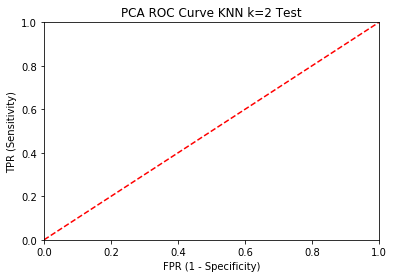

In [16]:
# plot knn roc curve
tpr = []
fpr = []

# split 80/20
p_train, p_test, p_train_labels, p_test_labels = train_test_split(p_training_imgs_0_35, training_labels, test_size=0.10, random_state=42)

for i in range(0, 105, 5):
    p0 = i*1.0 / 100.0
    p1 = 1.0 - p0
    print('p0', p0, 'p1', p1)
    y_pred_knn = knn(p_train, p_train_labels, p_test, p0, p1, 2)
    performance_metrics = get_metrics(p_test_labels, y_pred_knn)
    tpr.append(performance_metrics[0])
    fpr.append(1 - performance_metrics[1])
    
plot_roc(fpr, tpr, 'PCA ROC Curve KNN k=2 Test')

In [17]:
print(tpr)

[0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896, 0.896]


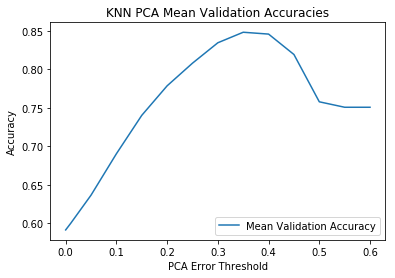

In [21]:
# plot KNN accuracies

def plot_accuracies(k, accuracies, methods, title, xlabel, ylabel):
    
    for i in range(len(accuracies)):
        plt.plot(k, accuracies[i], label=methods[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

k = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6] 
accuracies = [[0.5913142857142858, 0.5999428571428571, 0.6364571428571428, 0.6902285714285714, 0.7401142857142857, 0.7784571428571428, 0.8078857142857144, 0.8343999999999999, 0.8480571428571428, 0.8456571428571429, 0.8191428571428572, 0.7577142857142857, 0.7506285714285713, 0.7506285714285713]] 
plot_accuracies(k, accuracies, ["Mean Validation Accuracy"], "KNN PCA Mean Validation Accuracies", "PCA Error Threshold", "Accuracy")

Elapsed Time: 3.94726300239563
Fold 1 accuracy: 0.8997142857142857
Elapsed Time: 3.9240756034851074
Fold 2 accuracy: 0.9037142857142857
Elapsed Time: 3.940302610397339
Fold 3 accuracy: 0.9042857142857142
Elapsed Time: 3.9551305770874023
Fold 4 accuracy: 0.91
Elapsed Time: 3.9362542629241943
Fold 5 accuracy: 0.9085714285714286
Mean validation accuracy: 0.905257142857143
Elapsed Time: 3.938312292098999
Fold 1 accuracy: 0.9022857142857142
Elapsed Time: 3.945418357849121
Fold 2 accuracy: 0.9034285714285715
Elapsed Time: 3.9205820560455322
Fold 3 accuracy: 0.9065714285714286
Elapsed Time: 3.937609910964966
Fold 4 accuracy: 0.908
Elapsed Time: 3.952509641647339
Fold 5 accuracy: 0.9082857142857143
Mean validation accuracy: 0.9057142857142857
Elapsed Time: 3.939148426055908
Fold 1 accuracy: 0.8931428571428571
Elapsed Time: 3.936225175857544
Fold 2 accuracy: 0.8911428571428571
Elapsed Time: 3.9229798316955566
Fold 3 accuracy: 0.8997142857142857
Elapsed Time: 3.9233298301696777
Fold 4 accuracy: 

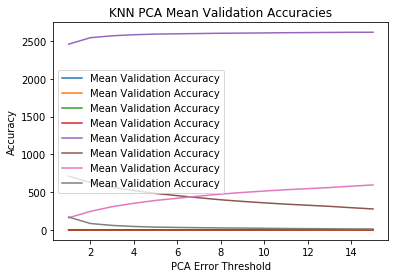

In [22]:
accuracies = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    accuracies.append(train_knn_with_validation(f_training_images, training_labels, i, folds=5))
    
plot_accuracies(k, [accuracies], ["Mean Validation Accuracy"], "KNN PCA Mean Validation Accuracies", "PCA Error Threshold", "Accuracy")

[array([9.05257143e-01, 9.35220295e-01, 9.38347979e-01, 8.15291807e-01,
       2.45700000e+03, 7.11400000e+02, 1.61400000e+02, 1.70200000e+02]), array([9.05714286e-01, 9.67659047e-01, 9.12093681e-01, 7.19414569e-01,
       2.54220000e+03, 6.27800000e+02, 2.45000000e+02, 8.50000000e+01]), array([8.94971429e-01, 9.77246170e-01, 8.92946834e-01, 6.47456142e-01,
       2.56740000e+03, 5.65000000e+02, 3.07800000e+02, 5.98000000e+01]), array([8.86171429e-01, 9.82577657e-01, 8.79813884e-01, 5.96079889e-01,
       2.58140000e+03, 5.20200000e+02, 3.52600000e+02, 4.58000000e+01]), array([8.77885714e-01, 9.85840753e-01, 8.69057595e-01, 5.52991553e-01,
       2.59000000e+03, 4.82600000e+02, 3.90200000e+02, 3.72000000e+01]), array([8.70742857e-01, 9.87360228e-01, 8.60867275e-01, 5.19734120e-01,
       2.59400000e+03, 4.53600000e+02, 4.19200000e+02, 3.32000000e+01]), array([8.63600000e-01, 9.88578849e-01, 8.53047091e-01, 4.87474366e-01,
       2.59720000e+03, 4.25400000e+02, 4.47400000e+02, 3.0000000

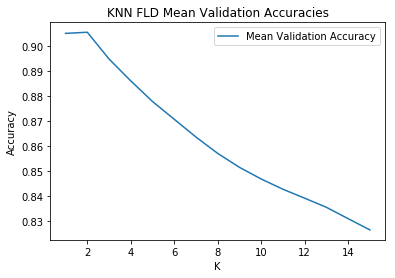

In [28]:
print(accuracies)
plot_accuracies(k, [[a[0] for a in accuracies]], ["Mean Validation Accuracy"], "KNN FLD Mean Validation Accuracies", "K", "Accuracy")

In [ ]:
# Naive Bayes

print(f_training_images.shape)
print(training_labels.shape)

# split 80/20
f_train, f_test, f_train_labels, f_test_labels = train_test_split(f_training_images, training_labels, test_size=0.20, random_state=42)

f_prior_class_0 = len(f_train_labels[f_train_labels[:]==0])/len(f_train_labels)
f_prior_class_1 = len(f_train_labels[f_train_labels[:]==1])/len(f_train_labels)



# KNN
y_pred_knn = knn(f_train, f_train_labels, f_test, prior_class_0, prior_class_1, 2)
performance_metrics = get_metrics(f_test_labels, y_pred_knn, save=True, name='f_knn.csv')
print('knn')

# DT
clf = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12, random_state=0).fit(f_train, f_train_labels)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
y_pred_dt = clf.predict(f_test)
performance_metrics = get_metrics(f_test_labels, y_pred_dt, save=True, name='f_dt.csv')
print('dt')

# SVM
clf = SVC(C=0.07, gamma= 3.0, kernel='rbf').fit(f_train, f_train_labels)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
y_pred_svm = clf.predict(f_test)
performance_metrics = get_metrics(f_test_labels, y_pred_dt, save=True, name='f_svm.csv')
print('svm')

# MPP 1
# MPP 2
# MPP 3